In [1]:
#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

#advectionGP
from advectionGP.models.mesh_1d_ode_model import AdjointSecondOrderODEModel as Model #Model module builds basic parts of the ODE problem, combines other classes into full model

'''To use other models in the class, such as the Advection Diffusion Reaction model, 
replace "AdjointSecondOrderODEModel" in the line above with "AdjointAdvectionDiffusionReaction" model
and adjust parameters as appropriate'''

from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
#from advectionGP.test import TestKernels #Unit test model


#Plotting tools
import matplotlib.pyplot as plt

In [2]:
fontS=20

In [3]:
avg=0.01 # time that an observation is taken for
tlocL = np.linspace(1,9,15) # observation start times
X= np.zeros((len(tlocL),2)) # initiate X
# Build sensor locations
X[:,0] = tlocL #lower time#
X[:,1] = X[:,0]+avg # upper time

In [4]:
sensors = FixedSensorModel(X,0) # establish sensor model arguments are sensor locations and spatial averaging (not applicable in 1D case so set to 0)

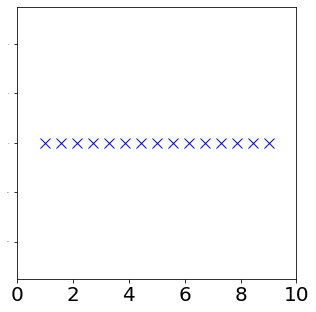

In [5]:
plt.rcParams["figure.figsize"] = (5,5)

plt.xlim(0,10)
#plt.title("Sensor Locations",fontsize=24)
plt.plot((X[:,1]-avg/2),np.zeros(len(X)),'xk',markersize=10,color='b');
plt.xticks(fontsize=fontS)
plt.yticks(fontsize=0)
plt.savefig('Paper2_2DSensorLocations.pdf')

In [6]:
np.random.seed(123)
k_0 = -0.01 #Diffusion coefficient
u=0.1
eta=0.1
noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0],[10])# edges of the grid - in units of time
kForward = EQ(0.3, 1.0) # generate EQ kernel arguments are lengthscale and variance
res = [500] # grid size for time

In [7]:
m = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kForward,sensormodel=sensors,k_0=k_0,u=u,eta=eta) #initiate PDE model to build concentration

dt, Nt = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
sourceGT=m.computeSourceFromPhi(z)# Compute ground truth source by approximating GP
#sourceGT = np.ones(m.resolution)  # Example constant source
concTrain=m.computeResponse(sourceGT) # Compute concentration - runs ODE forward model
yTrain= m.computeObservations(addNoise='TRUE') # Compute observations with noise uses m.sensormodel for observation locations

In [8]:
#%%timeit
np.random.seed(124)
N_feat =200 #Number of features used to infer the source
kInverse = EQ(0.3, 1.0) # Initiate kernel for inverse problem
#x=[1,1,-1]
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=sensors,k_0=k_0,u=u,eta=eta) #Initiate new model for inference
mInfer.computeModelRegressors() # Compute regressor matrix 
meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
concInfer=mInfer.computeResponse(sourceInfer) # Generates estimated concentration from inferred source



Computing SS...
Inverting SS...
Computing meanZ
Done


In [9]:
meanSource, varSource  = mInfer.computeSourceDistribution(meanZ,covZ)

In [10]:
sourceInfer.shape

(500,)

In [11]:
np.linspace((0,10),Nt)

array([[  0.        ,  10.        ],
       [ 10.20408163,  20.        ],
       [ 20.40816327,  30.        ],
       [ 30.6122449 ,  40.        ],
       [ 40.81632653,  50.        ],
       [ 51.02040816,  60.        ],
       [ 61.2244898 ,  70.        ],
       [ 71.42857143,  80.        ],
       [ 81.63265306,  90.        ],
       [ 91.83673469, 100.        ],
       [102.04081633, 110.        ],
       [112.24489796, 120.        ],
       [122.44897959, 130.        ],
       [132.65306122, 140.        ],
       [142.85714286, 150.        ],
       [153.06122449, 160.        ],
       [163.26530612, 170.        ],
       [173.46938776, 180.        ],
       [183.67346939, 190.        ],
       [193.87755102, 200.        ],
       [204.08163265, 210.        ],
       [214.28571429, 220.        ],
       [224.48979592, 230.        ],
       [234.69387755, 240.        ],
       [244.89795918, 250.        ],
       [255.10204082, 260.        ],
       [265.30612245, 270.        ],
 

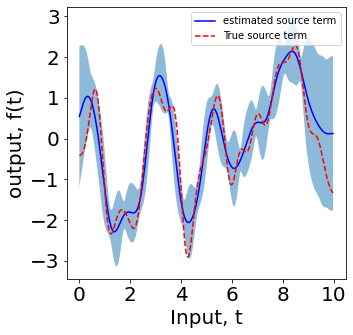

In [12]:
xtest=np.arange(0,10,0.02)

#plt.figure(figsize=(15, 10))

plt.plot(xtest,sourceInfer,'b-')
plt.plot(xtest,sourceGT,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,sourceInfer-1.96*np.sqrt(varSource),sourceInfer+1.96*np.sqrt(varSource),alpha=0.5)
plt.legend(labels=["estimated source term","True source term"])
#plt.title("Source function ",fontsize=fontS)
plt.xlabel("Input, t",fontsize=fontS)
plt.ylabel("output, f(t)",fontsize=fontS)
plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
#plt.ylim([-5,5])

plt.show()

In [13]:
concLower=mInfer.computeResponse(sourceInfer-1.96*np.sqrt(varSource))
concUpper=mInfer.computeResponse(sourceInfer+1.96*np.sqrt(varSource))

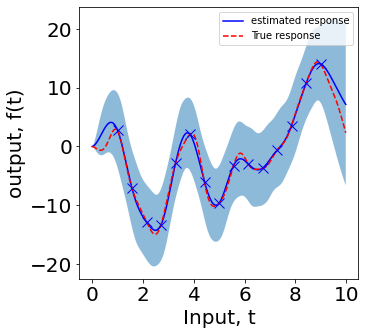

In [14]:
plt.plot(xtest,concInfer,'b-')
plt.plot(xtest,concTrain,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,concLower,concUpper,alpha=0.5)
plt.legend(labels=["estimated response","True response"])
#plt.title("Concentration",fontsize=fontS)
plt.xlabel("Input, t",fontsize=fontS)
plt.ylabel("output, f(t)",fontsize=fontS)
plt.plot((X[:,1]-avg/2),yTrain,'xk',markersize=10,color='b');
plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
#plt.ylim([-5,5])
plt.show()

In [15]:
#%%timeit
np.random.seed(124)
N_feat =100 #Number of features used to infer the source
kInverse = EQ(0.3, 1.0) # Initiate kernel for inverse problem
#x=[1,1,-1]
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=sensors,k_0=k_0,u=u,eta=eta) #Initiate new model for inference
mInfer.computeModelRegressors() # Compute regressor matrix 
meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
concInfer=mInfer.computeResponse(sourceInfer) # Generates estimated concentration from inferred source



Computing SS...
Inverting SS...
Computing meanZ
Done


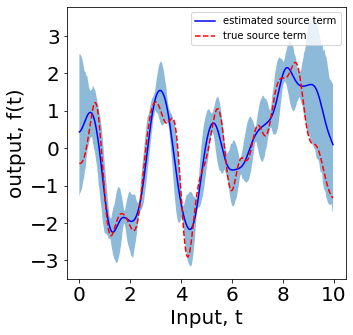

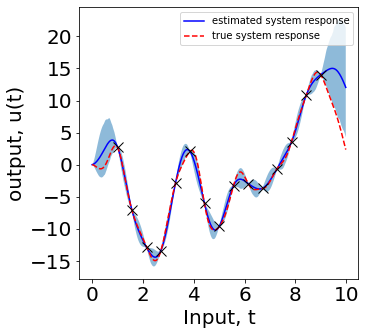

In [16]:
source_samples = []
conc_samples=[]    

for z_samp in np.random.multivariate_normal(meanZ, covZ,200):
    source_samples.append(mInfer.computeSourceFromPhi(z_samp))
    conc_samples.append(mInfer.computeResponse(mInfer.computeSourceFromPhi(z_samp)))
source_samples=np.array(source_samples)
conc_samples=np.array(conc_samples)

source_lower_ci = np.percentile(source_samples,2.5,0)
source_upper_ci = np.percentile(source_samples,97.5,0)
source_mean = np.percentile(source_samples,50,0)

conc_lower_ci = np.percentile(conc_samples,2.5,0)
conc_upper_ci = np.percentile(conc_samples,97.5,0)
conc_mean = np.percentile(conc_samples,50,0)

#plt.figure(figsize=(15, 10))

plt.plot(xtest,sourceInfer,'b-')
plt.plot(xtest,sourceGT,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,source_lower_ci,source_upper_ci,alpha=0.5)
plt.legend(labels=["estimated source term","true source term"])
#plt.title("Source function ",fontsize=fontS)
plt.xlabel("Input, t",fontsize=fontS)
plt.ylabel("output, f(t)",fontsize=fontS)
#plt.ylim([-5,5])
plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
plt.savefig('Paper2_1DSource.pdf',bbox_inches='tight' )
plt.show()

#plt.figure(figsize=(15, 10))

plt.plot(xtest,concInfer,'b-')
plt.plot(xtest,concTrain,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,conc_lower_ci,conc_upper_ci,alpha=0.5)
plt.legend(labels=["estimated system response","true system response"])
plt.plot((X[:,1]-avg/2),yTrain,'xk',markersize=10,color='black');
#plt.title("Concentration",fontsize=fontS)b
plt.xlabel("Input, t",fontsize=fontS)
plt.ylabel("output, u(t)",fontsize=fontS)
plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
#plt.ylim([-5,5])
plt.savefig('Paper2_1DResponse.pdf' ,bbox_inches='tight' )
plt.show()

In [17]:
#%%timeit
np.random.seed(124)
N_feat =1000 #Number of features used to infer the source
kInverse = EQ(0.3, 1.0) # Initiate kernel for inverse problem
#x=[1,1,-1]
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=sensors,k_0=k_0,u=u,eta=eta) #Initiate new model for inference
mInfer.computeModelRegressors() # Compute regressor matrix 
meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
concInfer=mInfer.computeResponse(sourceInfer) # Generates estimated concentration from inferred source



Computing SS...
Inverting SS...
Computing meanZ
Done


In [18]:
from advectionGP.gradient import SquaredErrorSamplingCost as cost

In [19]:
x = np.array([0.1,0.1,-0.01])#+np.random.normal(0,0.1,3)

In [20]:
samples=cost.generateQSampleLocations(model=mInfer,nSamp=50)

In [21]:
cost.costResponseDerivativeSystem(x,model=mInfer,obs=yTrain,obsloc=(X[:,0:1]-X[:,1:])/2,sample=samples)

Computing SS...
Inverting SS...
Computing meanZ
Done


array([-1.08068287,  1.82290455,  1.36163375])

In [22]:
ca=cost.costFunctionSystem(np.array([0.1,0.1+1e-8,-0.01]),model=mInfer,obs=yTrain,obsloc=(X[:,0:1]-X[:,1:])/2,sample=samples)
cb=cost.costFunctionSystem(np.array([0.1,0.1-1e-8,-0.01]),model=mInfer,obs=yTrain,obsloc=(X[:,0:1]-X[:,1:])/2,sample=samples)
c=(ca-cb)/(2*1e-8)

Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done


In [23]:
c

1.8229045446738201

In [24]:
reps=100

In [25]:
k_0v = np.linspace(-0.1,-0.01,reps)
uv = np.linspace(0.1,2,reps)
etav = np.linspace(0.1,2,reps)

In [26]:
dL=np.zeros((3,reps))
dL[:,0]

array([0., 0., 0.])

In [27]:
dLu=np.zeros((3,reps))
dLeta=np.zeros((3,reps))
dLk=np.zeros((3,reps))
for i in range(reps):
    x=np.array([uv[i],eta,k_0])
    dLu[:,i]=cost.costResponseDerivativeSystem(x,model=mInfer,obs=yTrain,obsloc=(X[:,0:1]-X[:,1:])/2,sample=samples)
    x=np.array([u,etav[i],k_0])
    dLeta[:,i]=cost.costResponseDerivativeSystem(x,model=mInfer,obs=yTrain,obsloc=(X[:,0:1]-X[:,1:])/2,sample=samples)
    x=np.array([u,eta,k_0v[i]])
    dLk[:,i]=cost.costResponseDerivativeSystem(x,model=mInfer,obs=yTrain,obsloc=(X[:,0:1]-X[:,1:])/2,sample=samples)

Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing mean

Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting

In [28]:
dL.T

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0

In [29]:
x

array([ 0.1 ,  0.1 , -0.01])

In [30]:
diff=[[1e-8,0,0],[0,1e-8,0],[0,0,1e-8]]
diff[0]

[1e-08, 0, 0]

In [31]:
dLManualu=np.zeros((3,reps))
dLManualeta=np.zeros((3,reps))
dLManualk=np.zeros((3,reps))
diff=[[1e-8,0,0],[0,1e-8,0],[0,0,1e-8]]
for i in range(reps):
    x=np.array([uv[i],eta,k_0])
    for j in range(3):
        ca=cost.costFunctionSystem(np.array(x+diff[j]),model=mInfer,obs=yTrain,obsloc=(X[:,0:1]-X[:,1:])/2,sample=samples);
        cb=cost.costFunctionSystem(np.array(x-diff[j]),model=mInfer,obs=yTrain,obsloc=(X[:,0:1]-X[:,1:])/2,sample=samples);
        print(ca)
        print(cb)
        dLManualu[j,i]=(ca-cb)/(2*1e-8)
    x=np.array([u,etav[i],k_0])
    for j in range(3):
        ca=cost.costFunctionSystem(np.array(x+diff[j]),model=mInfer,obs=yTrain,obsloc=(X[:,0:1]-X[:,1:])/2,sample=samples);
        cb=cost.costFunctionSystem(np.array(x-diff[j]),model=mInfer,obs=yTrain,obsloc=(X[:,0:1]-X[:,1:])/2,sample=samples);
        print(ca)
        print(cb)
        dLManualeta[j,i]=(ca-cb)/(2*1e-8)
    x=np.array([u,eta,k_0v[i]])
    for j in range(3):
        ca=cost.costFunctionSystem(np.array(x+diff[j]),model=mInfer,obs=yTrain,obsloc=(X[:,0:1]-X[:,1:])/2,sample=samples);
        cb=cost.costFunctionSystem(np.array(x-diff[j]),model=mInfer,obs=yTrain,obsloc=(X[:,0:1]-X[:,1:])/2,sample=samples);
        print(ca)
        print(cb)
        dLManualk[j,i]=(ca-cb)/(2*1e-8)

Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.12358998484385111
0.12359000645749987
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.1235900138797114
0.1235899774216205
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.1235900092670013
0.12358998203434124
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.12358998484385111
0.12359000645749987
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.1235900138797114
0.1235899774216205
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.1235900092670013
0.12358998203434124
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.01051928385401039
0.01

Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.10856477773363565
0.10856476741806136
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.255870964097998
0.2558709892914778
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.25587098160871424
0.25587097178075546
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.2558709659774196
0.25587098741205316
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.011478332067290051
0.0114783313781038
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.011478332785496521
0.011478330659902846
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.011478333659009254
0.0114783297863

Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.27973079100497505
0.27973079013895674
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.2797307769325773
0.27973080421135915
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.01265476486243559
0.012654763568779528
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.012654765782529461
0.012654762648687558
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.012654766617950128
0.012654761813258785
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.1474518424897825
0.1474518368579528
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.14745183928316516
0.1474518400645713
Computing

Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.014131283897787271
0.014131281891656435
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.014131285106880866
0.014131280682570718
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.014131285940629843
0.01413127984881217
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.17597579707640806
0.1759757928198627
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.1759757926336091
0.17597579726266038
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.175975795993164
0.17597579390310575
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.2787664493840953
0.27876645257046606
Computing SS...
Inverting 

Inverting SS...
Computing meanZ
Done
0.016020863133876222
0.016020855278305653
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.19688758835710057
0.19688758529159844
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.19688758389830519
0.19688758975039555
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.19688758740605827
0.1968875862426379
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.27532159929901456
0.27532160026456454
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.2753215995023205
0.2753216000612591
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.27532159436217674
0.27532160520140614
Computing SS...
Inverting SS...
Computing meanZ


Done
0.21193414824604473
0.2119341542137785
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.21193415157853784
0.21193415088128542
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.2725260172344697
0.2725260173769408
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.27252601709978624
0.2725260175116245
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.2725260141187255
0.27252602049268787
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.018947371704283275
0.01894736793934476
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.018947374064253075
0.018947365579366653
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS

Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.27052617156952447
0.2705261718588054
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.27052616992015227
0.2705261735081792
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.02229024191148985
0.02229023740784968
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.022290245186694996
0.02229023413264707
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.022290246637304313
0.022290232682030852
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.2243898305867947
0.2243898290430406
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.22438982702753665
0.2243898326022

Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.026638507151808273
0.026638502139322395
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.026638511689493747
0.026638497601638403
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.026638513686863628
0.02663849560427659
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.2321006673349403
0.23210066617742603
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.23210066420764563
0.2321006693047206
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.2321006668959044
0.23210066661646186
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.26893270073881115
0.26893270052871715
Computing SS...
Invertin

Computing meanZ
Done
0.03223634489664497
0.03223632177861523
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.23793421220361197
0.23793421131945805
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.23793420945822608
0.23793421406484122
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.23793421185976282
0.23793421166330644
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.2679874813532185
0.2679874811592292
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.26798748118653476
0.26798748132591316
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.2679874808271872
0.2679874816852607
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS..

Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.2424272286373732
0.24242722849440798
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.2672937309280172
0.26729373076861007
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.26729373079632895
0.2672937309002984
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.2672937306509182
0.2672937310457087
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.040666901149901694
0.04066689673374889
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.04066690994798646
0.04066688793564144
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.04066691396231857
0.0406668839213341

Inverting SS...
Computing meanZ
Done
0.2667683725058979
0.2667683725859363
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.2667683724617524
0.2667683726300814
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.049742779421799804
0.04974277654573101
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.04974279099281739
0.04974276497471512
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.04974279626574413
0.04974275970179157
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.24645495307260754
0.24645495255082575
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.24645495097918754
0.24645495464424289
Computing SS...
Inverting SS...
Computing meanZ
Do

Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.06060394213161283
0.06060391218553138
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.060603948655597206
0.06060390566152787
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.24914747502337753
0.24914747460505965
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.24914747316248706
0.24914747646594712
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.24914747485372518
0.24914747477471114
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.2662981607020326
0.26629816061156514
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.2662981606261729
0.2662981606874

Computing meanZ
Done
0.25131893994372473
0.2513189396042817
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.25131893828126595
0.25131894126674437
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.2513189398051546
0.25131893974285247
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.26597926688094153
0.2659792668121936
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.265979266821508
0.265979266871627
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.26597926681435813
0.2659792668787762
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.07529509926038687
0.07529510358464307
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
In

Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.26571540490834133
0.265715404855306
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.26571540486085554
0.26571540490279183
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.2657154048375342
0.26571540492611256
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.08896474293811181
0.08896475225310327
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.08896476586919463
0.08896472932201713
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.08896477294151928
0.08896472224970993
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.2533533034422244
0.2533533031725752

Done
0.2654925790461983
0.2654925791696431
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.10250691313741092
0.10250692775233337
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.10250693937344442
0.10250690151631074
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.10250694429992256
0.10250689658983418
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.2547682849150611
0.25476828469139007
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.25476828359131554
0.25476828601513696
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.25476828482302316
0.25476828478342817
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS.

Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.11448456043973869
0.11448452116752748
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.2559469725419981
0.25594697235486874
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.2559469713419088
0.255946973554961
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.2559469724648821
0.25594697243198533
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.26527197017396087
0.26527197014025344
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.26527197014200804
0.2652719701722062
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing SS...
Inverting SS...
Computing meanZ
Done
0.2652719700756178
0.26527197023859594
Computing SS...
I

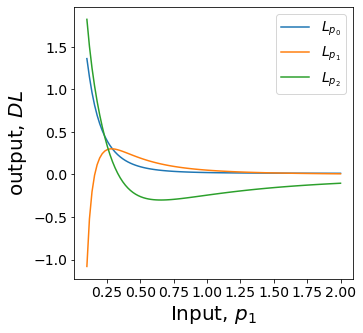

In [32]:
plt.plot(uv,dLu[(2,0,1),:].T)
plt.legend(labels=["$L_{p_0}$","$L_{p_1}$","$L_{p_2}$"],fontsize=14)
plt.xlabel("Input, $p_1$",fontsize=fontS)
plt.ylabel("output, $DL$",fontsize=fontS)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.ylim([-5,5])
plt.savefig('Paper2_Gradientp1Vary.pdf' )
plt.show()

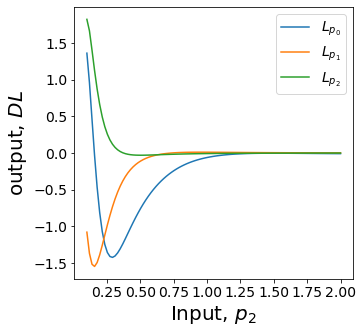

In [33]:
plt.plot(etav,dLeta[(2,0,1),:].T)
plt.legend(labels=["$L_{p_0}$","$L_{p_1}$","$L_{p_2}$"],fontsize=14)
plt.xlabel("Input, $p_2$",fontsize=fontS)
plt.ylabel("output, $DL$",fontsize=fontS)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.ylim([-5,5])
plt.savefig('Paper2_Gradientp2Vary.pdf' )
plt.show()

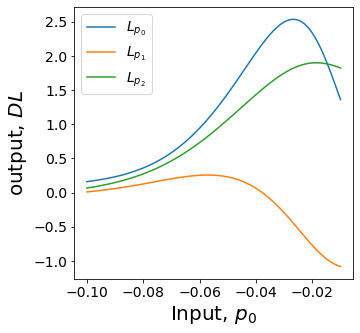

In [34]:
plt.plot(k_0v,dLk[(2,0,1),:].T)
plt.legend(labels=["$L_{p_0}$","$L_{p_1}$","$L_{p_2}$"],fontsize=14)
plt.xlabel("Input, $p_0$",fontsize=fontS)
plt.ylabel("output, $DL$",fontsize=fontS)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.ylim([-5,5])
plt.savefig('Paper2_Gradientp0Vary.pdf' )
plt.show()

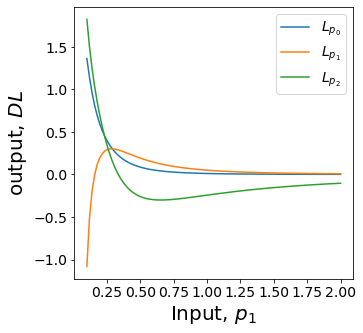

In [35]:
plt.plot(uv,dLManualu[(2,0,1),:].T)
plt.legend(labels=["$L_{p_0}$","$L_{p_1}$","$L_{p_2}$"],fontsize=14)
plt.xlabel("Input, $p_1$",fontsize=fontS)
plt.ylabel("output, $DL$",fontsize=fontS)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.ylim([-5,5])
plt.savefig('Paper2_GradientManualp1Vary.pdf' )
plt.show()

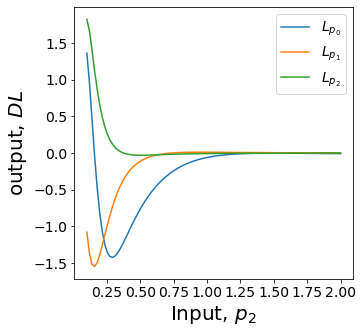

In [36]:
plt.plot(etav,dLManualeta[(2,0,1),:].T)
plt.legend(labels=["$L_{p_0}$","$L_{p_1}$","$L_{p_2}$"],fontsize=14)
plt.xlabel("Input, $p_2$",fontsize=fontS)
plt.ylabel("output, $DL$",fontsize=fontS)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.ylim([-5,5])
plt.savefig('Paper2_GradientManualp2Vary.pdf' )
plt.show()

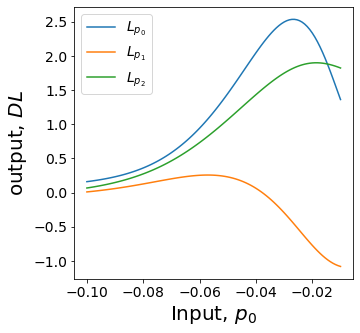

In [37]:
plt.plot(k_0v,dLManualk[(2,0,1),:].T)
plt.legend(labels=["$L_{p_0}$","$L_{p_1}$","$L_{p_2}$"],fontsize=14)
plt.xlabel("Input, $p_0$",fontsize=fontS)
plt.ylabel("output, $DL$",fontsize=fontS)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.ylim([-5,5])
plt.savefig('Paper2_GradientManualp0Vary.pdf' )
plt.show()

# Lengthscale Gradient

In [39]:
#%%timeit
np.random.seed(124)
N_feat =1000 #Number of features used to infer the source
kInverse = EQ(0.3, 1.0) # Initiate kernel for inverse problem
#x=[1,1,-1]
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=sensors,k_0=k_0,u=u,eta=eta) #Initiate new model for inference
mInfer.computeModelRegressors() # Compute regressor matrix 
meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
concInfer=mInfer.computeResponse(sourceInfer) # Generates estimated concentration from inferred source



Computing SS...
Inverting SS...
Computing meanZ
Done


In [40]:
reps=50
samples=cost.generateQSampleLocations(model=mInfer,nSamp=50)

In [41]:
ls = np.linspace(0.1,5,reps)
dL=np.zeros((1,reps))
for i in range(reps):
    x=ls[i]
    dL[:,i]=cost.costResponseDerivativeLengthscale(x,model=mInfer,obs=yTrain,obsloc=(X[:,0:1]-X[:,1:])/2,sample=samples)



Computing SS...
Inverting SS...
Computing meanZ
Done






































































































Computing SS...
Inverting SS...
Computing meanZ
Done


































































KeyboardInterrupt: 

In [ ]:
dLManual=np.zeros(reps)
costs=np.zeros(reps)
diff=[[1e-8,0,0],[0,1e-8,0],[0,0,1e-8]]
for i in range(reps):
    x=ls[i]
    ca=cost.costFunctionLengthscale(lengthscale=x+1e-8,model=mInfer,obs=yTrain,obsloc=np.array([(X[:,0]-X[:,1])/2]).T,sample=samples)
    cb=cost.costFunctionLengthscale(lengthscale=x-1e-8,model=mInfer,obs=yTrain,obsloc=np.array([(X[:,0]-X[:,1])/2]).T,sample=samples)
    costs[i]=ca
    c=(ca-cb)/(2*1e-8)
    print(c)
    dLManual[i]=c

In [ ]:
dLManual

In [ ]:
plt.plot(ls,dL.T)
plt.legend(labels=["$L_{\lambda}$"],fontsize=14)
plt.xlabel("Input, $\lambda$",fontsize=fontS)
plt.ylabel("output, $DL$",fontsize=fontS)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.ylim([-5,5])
plt.savefig('Paper2_GradientLVary.pdf' )
plt.show()

In [ ]:
plt.plot(ls,dLManual.T)
plt.legend(labels=["$L_{\lambda}$"],fontsize=14)
plt.xlabel("Input, $\lambda$",fontsize=fontS)
plt.ylabel("output, $DL$",fontsize=fontS)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.ylim([-5,5])
plt.savefig('Paper2_GradientManualLVary.pdf' )
plt.show()

In [ ]:
plt.plot(ls,costs.T)
plt.xlabel("Input, $\lambda$",fontsize=fontS)
plt.ylabel("output, $Z$",fontsize=fontS)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.ylim([-5,5])
plt.savefig('Paper2_GradientLCost.pdf' )
plt.show()

In [ ]:
#%%timeit
np.random.seed(124)
N_feat =100 #Number of features used to infer the source
kInverse = EQ(0.3, 1.0) # Initiate kernel for inverse problem
#x=[1,1,-1]
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=sensors,k_0=k_0,u=1,eta=eta) #Initiate new model for inference
mInfer.computeModelRegressors() # Compute regressor matrix 
meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
concInfer=mInfer.computeResponse(sourceInfer) # Generates estimated concentration from inferred source 

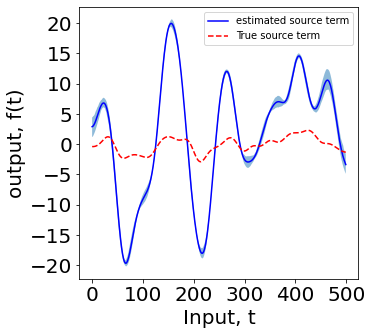

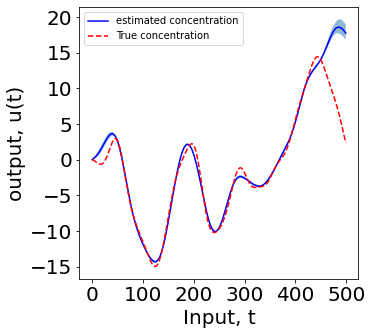

In [157]:
source_samples = []
conc_samples=[]    

for z_samp in np.random.multivariate_normal(meanZ, covZ,200):
    source_samples.append(mInfer.computeSourceFromPhi(z_samp))
    conc_samples.append(mInfer.computeResponse(mInfer.computeSourceFromPhi(z_samp)))
source_samples=np.array(source_samples)
conc_samples=np.array(conc_samples)

source_lower_ci = np.percentile(source_samples,2.5,0)
source_upper_ci = np.percentile(source_samples,97.5,0)
source_mean = np.percentile(source_samples,50,0)

conc_lower_ci = np.percentile(conc_samples,2.5,0)
conc_upper_ci = np.percentile(conc_samples,97.5,0)
conc_mean = np.percentile(conc_samples,50,0)

xtest=np.arange(Nt)

#plt.figure(figsize=(15, 10))

plt.plot(xtest,sourceInfer,'b-')
plt.plot(xtest,sourceGT,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,source_lower_ci,source_upper_ci,alpha=0.5)
plt.legend(labels=["estimated source term","True source term"])
#plt.title("Source function ",fontsize=fontS)
plt.xlabel("Input, t",fontsize=fontS)
plt.ylabel("output, f(t)",fontsize=fontS)
#plt.ylim([-5,5])
plt.savefig('Paper2_1DSource_WrongU.pdf' )
plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
plt.show()

#plt.figure(figsize=(15, 10))

plt.plot(xtest,concInfer,'b-')
plt.plot(xtest,concTrain,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,conc_lower_ci,conc_upper_ci,alpha=0.5)
plt.legend(labels=["estimated concentration","True concentration"])
#plt.title("Concentration",fontsize=fontS)
plt.xlabel("Input, t",fontsize=fontS)
plt.ylabel("output, u(t)",fontsize=fontS)
plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
#plt.ylim([-5,5])
plt.savefig('Paper2_1DResponse_WrongU.pdf' )
plt.show()

### ADR 1D

In [53]:
#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

#advectionGP

from advectionGP.models.mesh_adr1d_model import AdjointAdvectionDiffusionReaction1DModel as Model

from advectionGP.wind import WindFixU#Wind model


from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.kernels import GaussianBases #Generates exponentiated quadratic kernel approximation
#from advectionGP.test import TestKernels #Unit test model


#Plotting tools
import matplotlib.pyplot as plt

In [54]:
# generate sensor locations for training data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(1,9,5) # lower time
xloc=np.linspace(1,9,5) # x locations
sensN = len(xloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X= np.zeros((obsN*sensN,3)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X[:,0] = np.asarray(np.meshgrid(tlocL,xloc)).reshape(2,sensN*obsN)[0] #lower time
X[:,2] = np.asarray(np.meshgrid(tlocL,xloc)).reshape(2,sensN*obsN)[1] # x location
X[:,1] = X[:,0]+0.1 # upper time

sensors = FixedSensorModel(X,0.001) # establish sensor model arguments are sensor locations and spatial averaging

In [55]:
np.random.seed(1)
k_0 = 0.05 #Diffusion
R=0.5
noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0,0],[10,10])# corners of the grid - in units of space
k = EQ(1, 2.0) # generate EQ kernel arguments are lengthscale and variance
res = [1000,100] # grid size for time, x and y

gg = []
for d in range(2):
    gg.append(np.linspace(boundary[0][d],boundary[1][d],res[d]))
        
coords=np.asarray(np.meshgrid(gg[0],gg[1],indexing='ij'))

u1 = 0.5*np.sin(2*coords[0])
u2 = 0*np.ones(res)
u=np.array([u1,u2])
windmodel=WindFixU(u) # establish fixed wind model
m = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=R) #initiate PDE model to build concentration

delta,Ns = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source

sourceGT=(m.computeSourceFromPhi(z))# Compute source

#sourceGT[500:999:,]=0

#sourceGT = np.zeros(m.resolution)
#x = np.linspace(0,10,50)

#sourceGT[:,0:50]=np.exp(-(1/1)*(x-5)**2)

c:\users\chris\documents\github\advectiongp\advectionGP\models\mesh_adr1d_model.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  if (delta[1]>=2*self.k_0/np.min(np.abs(self.u))): print("WARNING: spatial grid size does not meet the finite difference advection diffusion stability criteria")


In [56]:
sourceGT[50:99,:].shape

(49, 100)

In [57]:
fontS=20

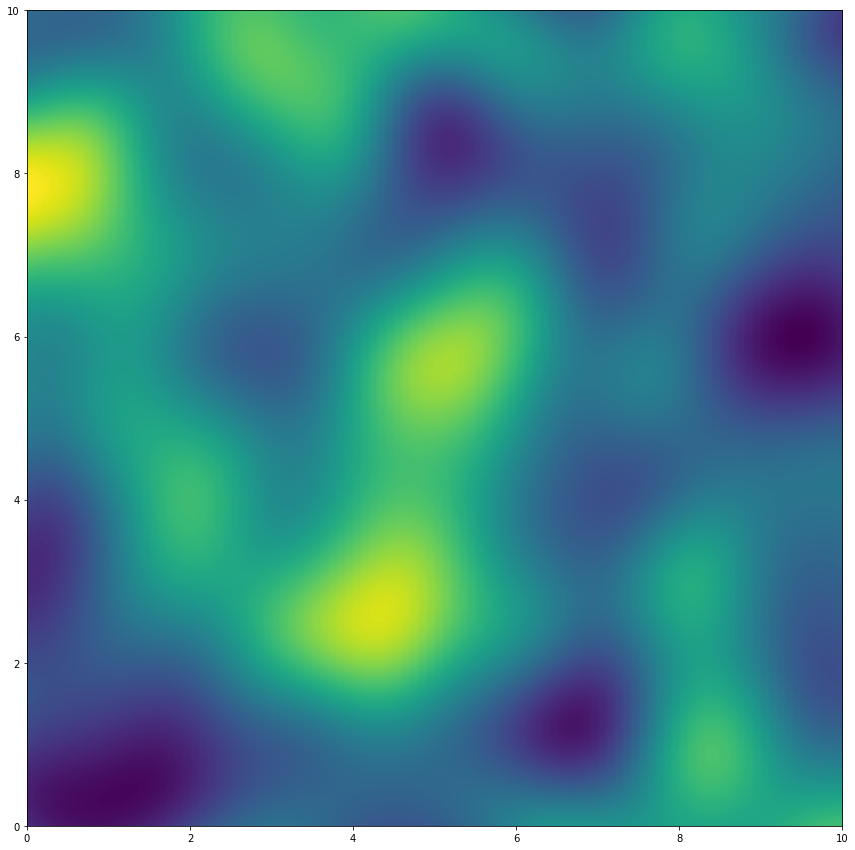

In [58]:
plt.imshow(sourceGT,extent=[0,10,0,10],origin='lower')

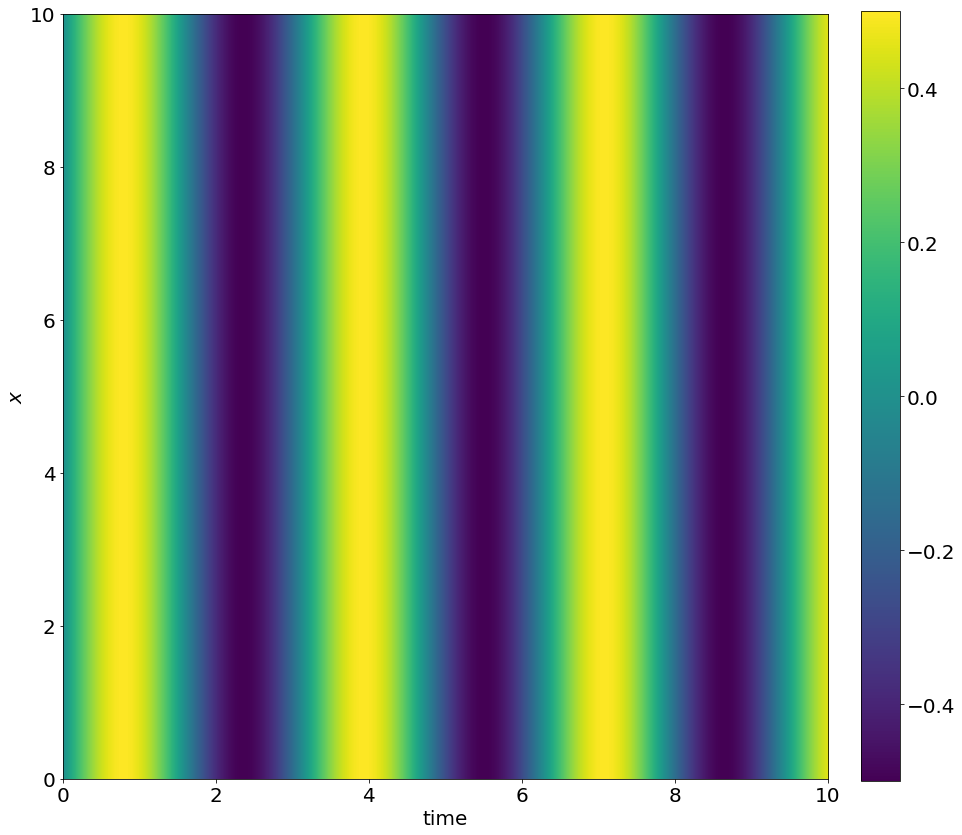

In [59]:
plt.imshow(u1.T,extent=[0,10,0,10],origin='lower')

plt.xlabel("time",fontsize=fontS)
plt.ylabel("$x$",fontsize=fontS)
plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
cb=plt.colorbar(fraction=0.046, pad=0.04)
cb.ax.tick_params(labelsize = fontS)
plt.savefig('Paper2_2DAdvection.pdf',bbox_inches='tight' )

In [60]:
m.sensormodel=sensors
concTrain=m.computeResponse(sourceGT) # Compute concentration - runs advection diffusion forward model
yTrain= m.computeObservations(addNoise=True) # Compute observations with noise uses m.sensormodel for observation locations

In [61]:
np.random.seed(1)
N_feat =1000 #Number of features used to infer the source
#k1 = EQ(0.5, 1.0) 
k2 = EQ(1, 2.0) 

mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k2,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=R) #Initiate new model for inference
regressInfer = mInfer.computeModelRegressors() # Compute regressor matrix
meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance
sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using inferred distributio
concInfer = mInfer.computeResponse(sourceInfer)

yOut = mInfer.computeObservations()

c:\users\chris\documents\github\advectiongp\advectionGP\models\mesh_adr1d_model.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  if (delta[1]>=2*self.k_0/np.min(np.abs(self.u))): print("WARNING: spatial grid size does not meet the finite difference advection diffusion stability criteria")




Computing SS...
Inverting SS...
Computing meanZ
Done


In [62]:
fontS = 20

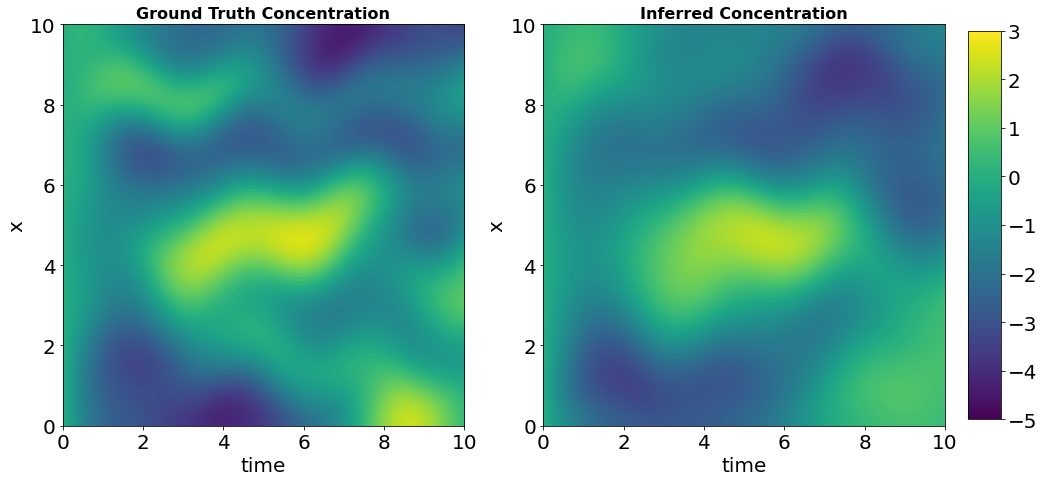

In [63]:
a=np.floor(np.min((np.min(concInfer),np.min(concTrain))))
b=np.ceil(np.max((np.max(concTrain),np.max(concInfer))))
plt.rcParams["figure.figsize"] = (15,15)
fig = plt.figure()

ploti = 0
for title, data in zip(['Ground Truth Concentration','Inferred Concentration'],[concTrain.T, concInfer.T]):
    ploti+=1
    plt.subplot(1,2,ploti)
    im1=plt.imshow(data, extent=[0,10,0,10],origin='lower') #fix t...
    #time = t*dt
    plt.xlabel("time",fontsize=fontS)
    plt.ylabel("x",fontsize=fontS)
    plt.xticks(fontsize=fontS)
    plt.yticks(fontsize=fontS)
    plt.clim(a,b)


    tick_font_size = 16
    plt.title(title, fontsize=16, fontweight='bold')
    #if ploti % 3 == 3:
    #    plt.colorbar(im1,fraction=0.046, pad=0.04)

fig.tight_layout(rect=[0.1, 0.2, 1, 1])

cbar_ax = fig.add_axes([1, 0.42, 0.03, 0.36])
cbar=fig.colorbar(im1, cax=cbar_ax,orientation='vertical')
#cbar = plt.colorbar(im3,fraction=0.046)
tick_font_size = 16
cbar.ax.tick_params(labelsize = fontS)
plt.savefig('Paper2_2DResponse.pdf' ,bbox_inches='tight')
plt.show()


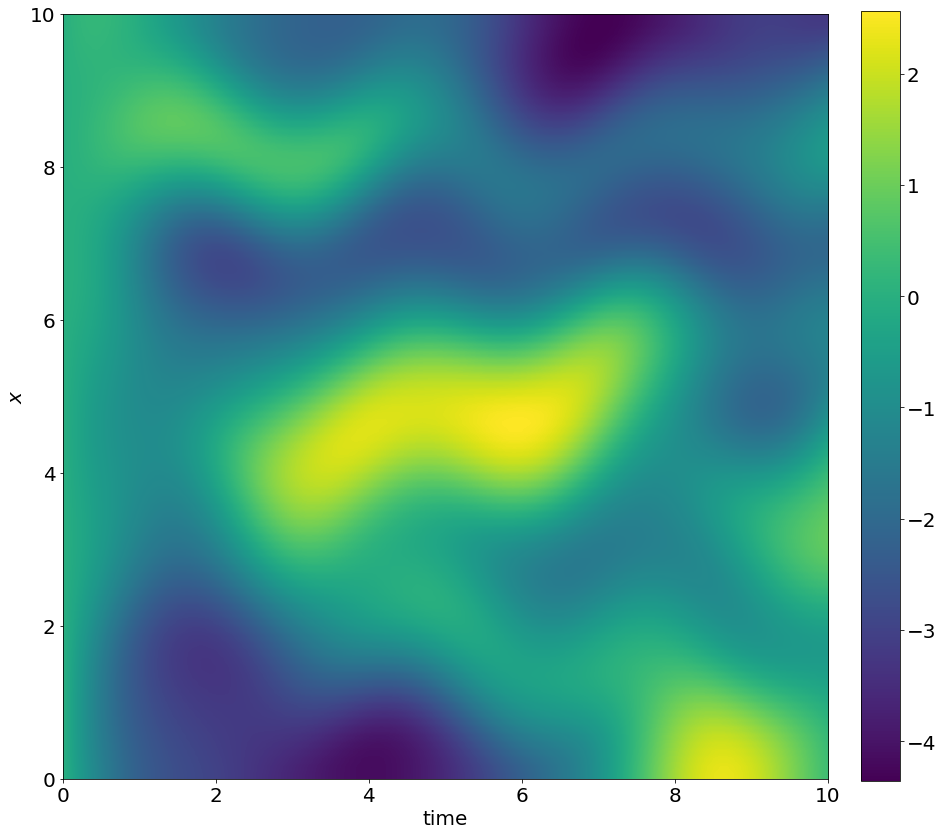

In [64]:
plt.imshow(concTrain.T,extent=[0,10,0,10],origin='lower')

plt.xlabel("time",fontsize=fontS)
plt.ylabel("$x$",fontsize=fontS)
plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
cb=plt.colorbar(fraction=0.046, pad=0.04)
cb.ax.tick_params(labelsize = fontS)
plt.savefig('Paper2_2DTrueResponse.pdf',bbox_inches='tight' )

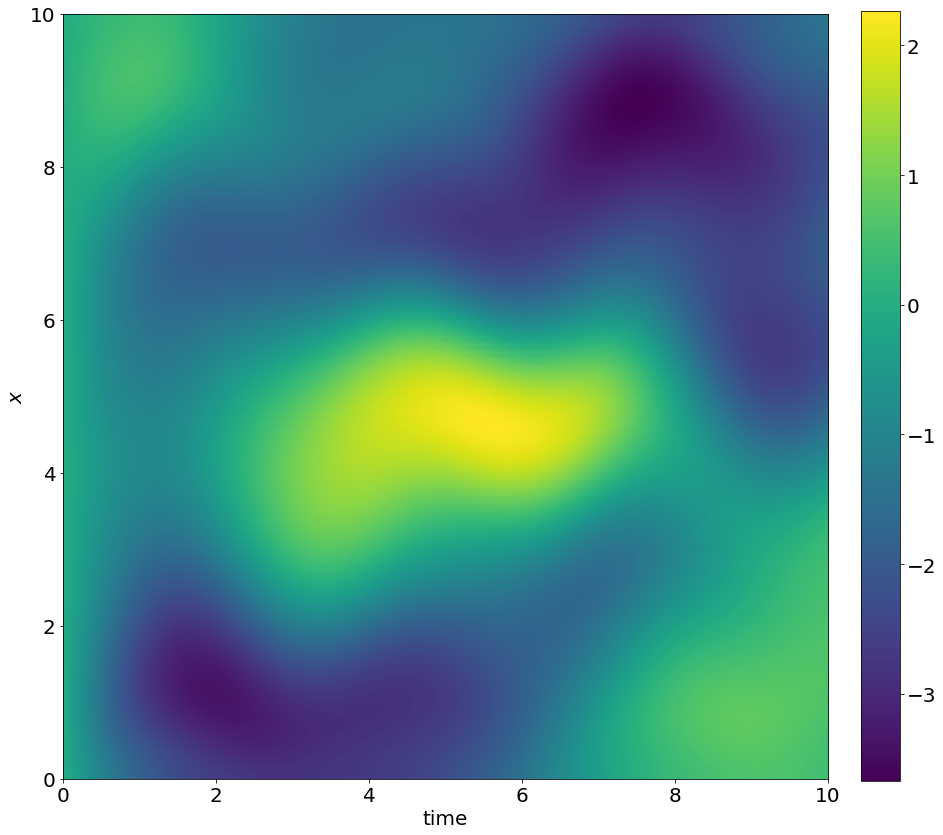

In [65]:
plt.imshow(concInfer.T,extent=[0,10,0,10],origin='lower')

plt.xlabel("time",fontsize=fontS)
plt.ylabel("$x$",fontsize=fontS)
plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
cb=plt.colorbar(fraction=0.046, pad=0.04)
cb.ax.tick_params(labelsize = fontS)
plt.savefig('Paper2_2DInferResponse.pdf',bbox_inches='tight' )

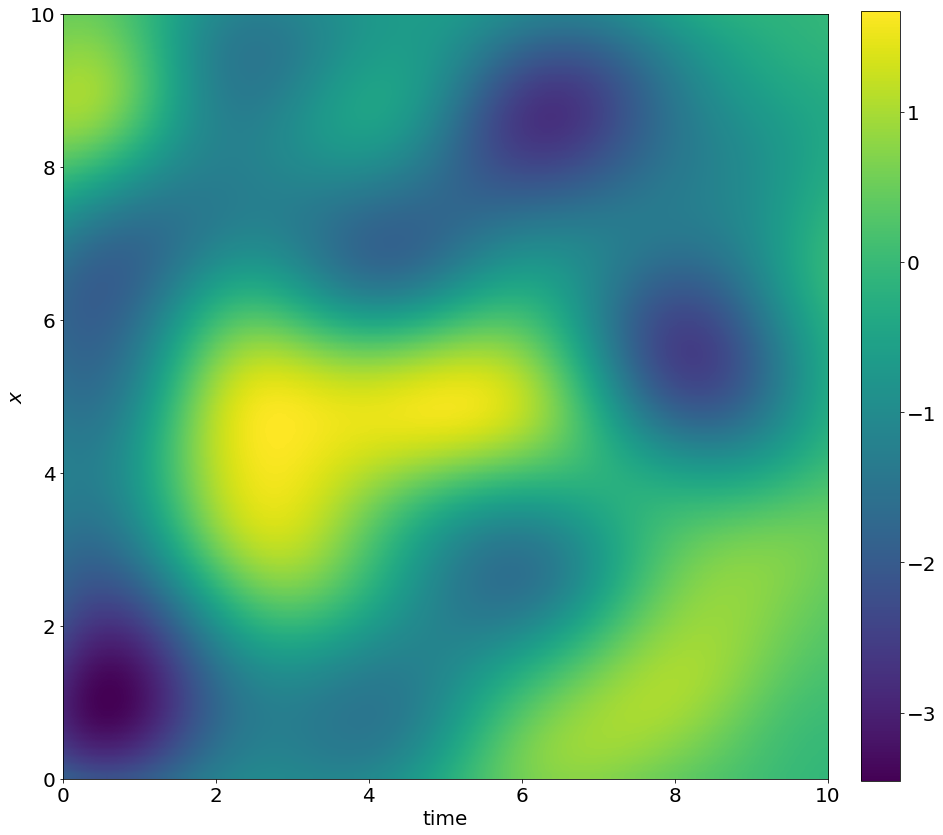

In [66]:
plt.imshow(sourceInfer.T,extent=[0,10,0,10],origin='lower')

plt.xlabel("time",fontsize=fontS)
plt.ylabel("$x$",fontsize=fontS)
plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
cb=plt.colorbar(fraction=0.046, pad=0.04)
cb.ax.tick_params(labelsize = fontS)
plt.savefig('Paper2_2DInferSource.pdf',bbox_inches='tight' )

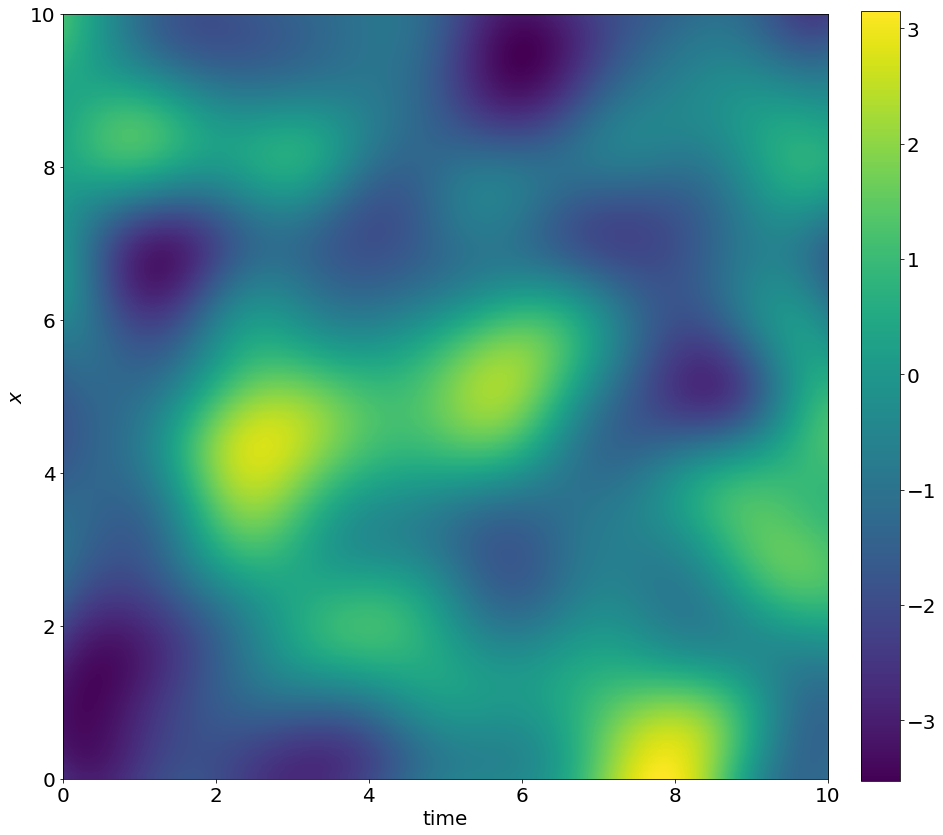

In [67]:
plt.imshow(sourceGT.T,extent=[0,10,0,10],origin='lower')

plt.xlabel("time",fontsize=fontS)
plt.ylabel("$x$",fontsize=fontS)
plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
cb=plt.colorbar(fraction=0.046, pad=0.04)
cb.ax.tick_params(labelsize = fontS)
plt.savefig('Paper2_2DTrueSource.pdf',bbox_inches='tight' )

In [ ]:
reps=5

In [ ]:
diff=[[1e-8,0,0],[0,1e-8,0],[0,0,1e-8]]
k_0v = np.linspace(0.01,0.5,reps)
uv = np.linspace(0.01,0.5,reps)
Rv = np.linspace(0,5,reps)

In [ ]:
dLu=np.zeros(reps)
dLk_0=np.zeros(reps)
dLR=np.zeros(reps)
for i in range(reps):
    x=np.array([uv[i],k_0,R])
    dLu[:,i]=cost.costResponseDerivativeSystem(x,model=mInfer,obs=yTrain,obsloc=np.array([(X[:,0]-X[:,1])/2,X[:,2]]).T,sample=samples)
    x=np.array([0.5,k_0v[i],R])
    dLk[:,i]=cost.costResponseDerivativeSystem(x,model=mInfer,obs=yTrain,obsloc=np.array([(X[:,0]-X[:,1])/2,X[:,2]]).T,sample=samples)
    x=np.array([0.5,k_0,Rv[i])
    dLR[:,i]=cost.costResponseDerivativeSystem(x,model=mInfer,obs=yTrain,obsloc=np.array([(X[:,0]-X[:,1])/2,X[:,2]]).T,sample=samples)            

In [ ]:
dLManualu=np.zeros((3,reps))
dLManualk_0=np.zeros((3,reps))
dLManualR=np.zeros((3,reps))
diff=[[1e-8,0,0],[0,1e-8,0],[0,0,1e-8]]
for i in range(reps):ye
    x=np.array([uv[i],k_0,R])
        ca=cost.costFunctionSystem(np.array(x+diff[j]),model=mInfer,obs=yTrain,obsloc=(X[:,0:1]-X[:,1:])/2,sample=samples);
        cb=cost.costFunctionSystem(np.array(x-diff[j]),model=mInfer,obs=yTrain,obsloc=(X[:,0:1]-X[:,1:])/2,sample=samples);
        print(ca)
        print(cb)
        dLManualu[j,i]=(ca-cb)/(2*1e-8)
    x=np.array([0.5,k_0v[i],R])
        ca=cost.costFunctionSystem(np.array(x+diff[j]),model=mInfer,obs=yTrain,obsloc=(X[:,0:1]-X[:,1:])/2,sample=samples);
        cb=cost.costFunctionSystem(np.array(x-diff[j]),model=mInfer,obs=yTrain,obsloc=(X[:,0:1]-X[:,1:])/2,sample=samples);
        print(ca)
        print(cb)
        dLManualk_0[j,i]=(ca-cb)/(2*1e-8)
    x=np.array([0.5,k_0,Rv[i]])
        ca=cost.costFunctionSystem(np.array(x+diff[j]),model=mInfer,obs=yTrain,obsloc=(X[:,0:1]-X[:,1:])/2,sample=samples);
        cb=cost.costFunctionSystem(np.array(x-diff[j]),model=mInfer,obs=yTrain,obsloc=(X[:,0:1]-X[:,1:])/2,sample=samples);
        print(ca)
        print(cb)
        dLManualR[j,i]=(ca-cb)/(2*1e-8)

In [68]:
mInfer.kernel.l2

array([1, 1])

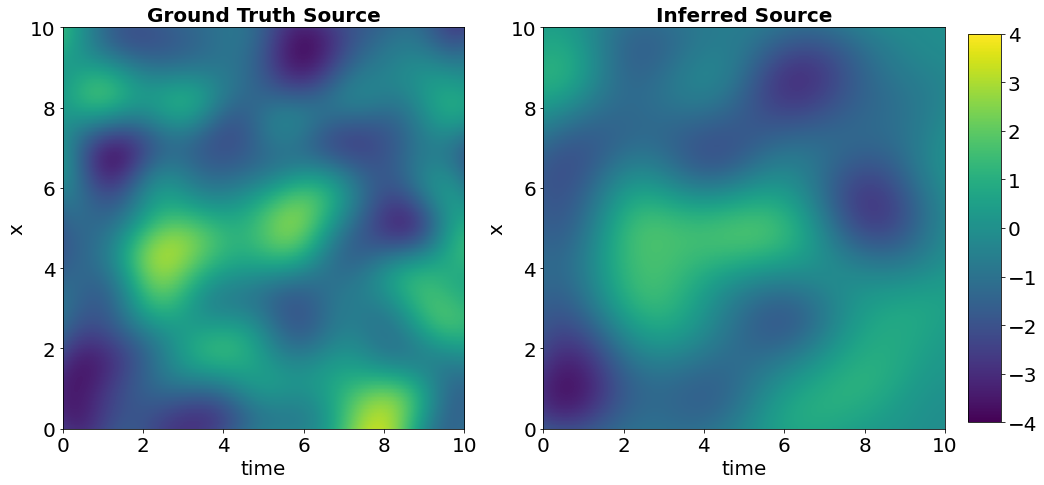

In [69]:
a=np.floor(np.min((np.min(sourceInfer),np.min(sourceGT))))
b=np.ceil(np.max((np.max(sourceInfer),np.max(sourceGT))))
plt.rcParams["figure.figsize"] = (15,15)
fig = plt.figure()

ploti = 0
for title, data in zip(['Ground Truth Source','Inferred Source'],[sourceGT.T, sourceInfer.T]):
    ploti+=1
    plt.subplot(1,2,ploti)
    im1=plt.imshow(data, extent=[0,10,0,10],origin='lower') #fix t...
    #time = t*dt
    plt.xlabel("time",fontsize=fontS)
    plt.ylabel("x",fontsize=fontS)
    plt.xticks(fontsize=fontS)
    plt.yticks(fontsize=fontS)
    plt.clim(a,b)


    tick_font_size = 16
    plt.title(title, fontsize=fontS, fontweight='bold')
    #if ploti % 3 == 3:
    #    plt.colorbar(im1,fraction=0.046, pad=0.04)

fig.tight_layout(rect=[0.1, 0.2, 1, 1])

cbar_ax = fig.add_axes([1, 0.42, 0.03, 0.36])
cbar=fig.colorbar(im1, cax=cbar_ax,orientation='vertical')
#cbar = plt.colorbar(im3,fraction=0.046)
tick_font_size = 16
cbar.ax.tick_params(labelsize = fontS)
plt.savefig('Paper2_2DSource.pdf' ,bbox_inches='tight')
plt.show()


In [20]:
meanSource, varSource  = mInfer.computeSourceDistribution(meanZ,covZ)

KeyboardInterrupt: 

In [ ]:
plt.imshow(varSource.T, extent=[0,10,0,10],origin='lower')
plt.xlabel("time",fontsize=fontS)
plt.ylabel("x",fontsize=fontS)
plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
cb=plt.colorbar(fraction=0.046, pad=0.04)
cb.ax.tick_params(labelsize = fontS)
plt.plot((X[:,0]+X[:,1])/2,X[:,2],'xk',markersize=15,color="white")
plt.savefig('Paper2_2DVar.pdf' )

# ADR 1D Single source

In [171]:
np.random.seed(1)
k_0 = 0.05 #Diffusion
R=0.0
noiseSD = 0.5 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0,0],[10,10])# corners of the grid - in units of space
k = EQ(1, 2.0) # generate EQ kernel arguments are lengthscale and variance
res = [1000,100] # grid size for time, x and y

gg = []
for d in range(2):
    gg.append(np.linspace(boundary[0][d],boundary[1][d],res[d]))
        
coords=np.asarray(np.meshgrid(gg[0],gg[1],indexing='ij'))

u1 = -0.2*np.ones(res)
u2 = 0*np.ones(res)
u=np.array([u1,u2])
windmodel=WindFixU(u) # establish fixed wind model
m = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=R) #initiate PDE model to build concentration

delta,Ns = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source

sourceGT = np.zeros(m.resolution)
x = np.linspace(0,10,1000)
y = np.linspace(0,10,100)
Gco=np.asarray(np.meshgrid(x,y,indexing='ij'))
sourceGT=np.exp(-(1/1)*(Gco[0]-2.5)**2)*np.exp(-(1/1)*(Gco[1]-7.5)**2)

#sourceGT[500:999:,]=0

In [172]:
m.sensormodel=sensors
concTrain=m.computeResponse(sourceGT) # Compute concentration - runs advection diffusion forward model
yTrain= m.computeObservations(addNoise=True) # Compute observations with noise uses m.sensormodel for observation locations

In [224]:
fontS=30

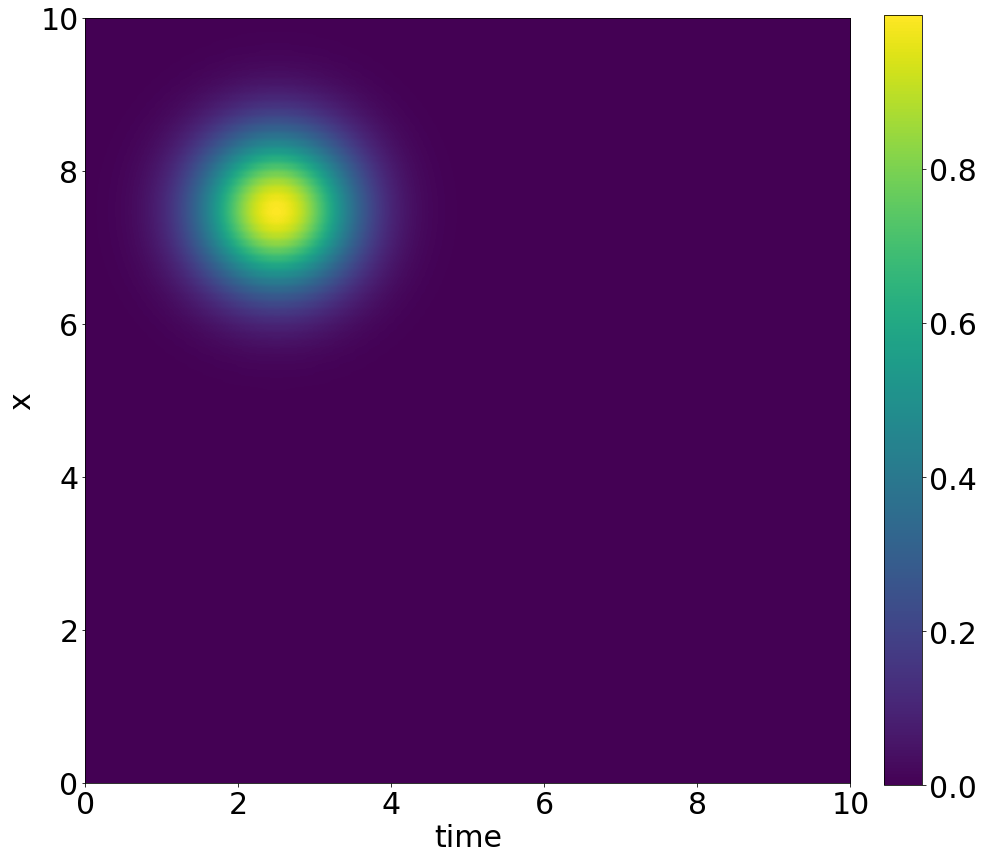

In [225]:
plt.imshow(sourceGT.T,extent=[0,10,0,10],origin='lower')
plt.xlabel("time",fontsize=fontS)
plt.ylabel("x",fontsize=fontS)
plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
cb=plt.colorbar(fraction=0.046, pad=0.04)
cb.ax.tick_params(labelsize = fontS)
plt.savefig('Paper2_ADRGSource.pdf' )

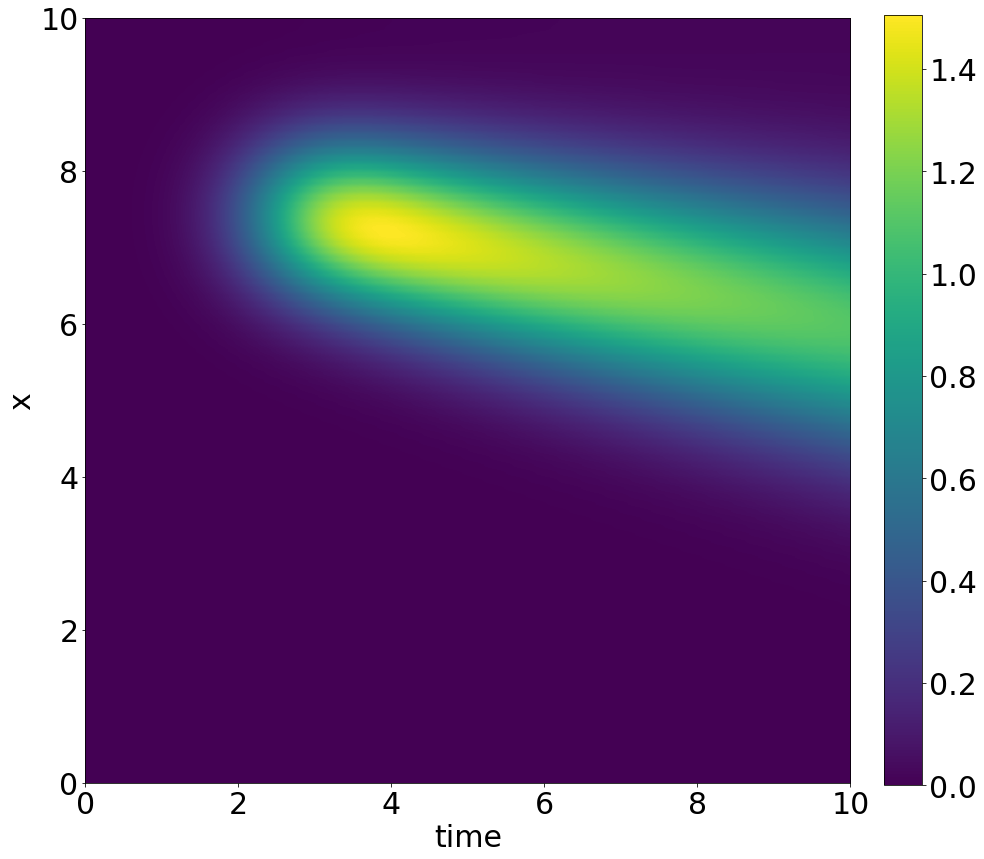

In [226]:
plt.imshow(concTrain.T,extent=[0,10,0,10],origin='lower')
plt.xlabel("time",fontsize=fontS)
plt.ylabel("x",fontsize=fontS)
plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
cb=plt.colorbar(fraction=0.046, pad=0.04)
cb.ax.tick_params(labelsize = fontS)
plt.savefig('Paper2_ADRLineConc.pdf' )

In [227]:
concTrain.shape

(1000, 100)

In [228]:
dudt=np.gradient(concTrain,delta[0], axis=0)
dudx=np.gradient(concTrain,delta[1], axis=1)
du2dx2=np.gradient(dudx,delta[1], axis=1)

In [239]:
sourceNew = dudt+1*dudx-0.2*du2dx2

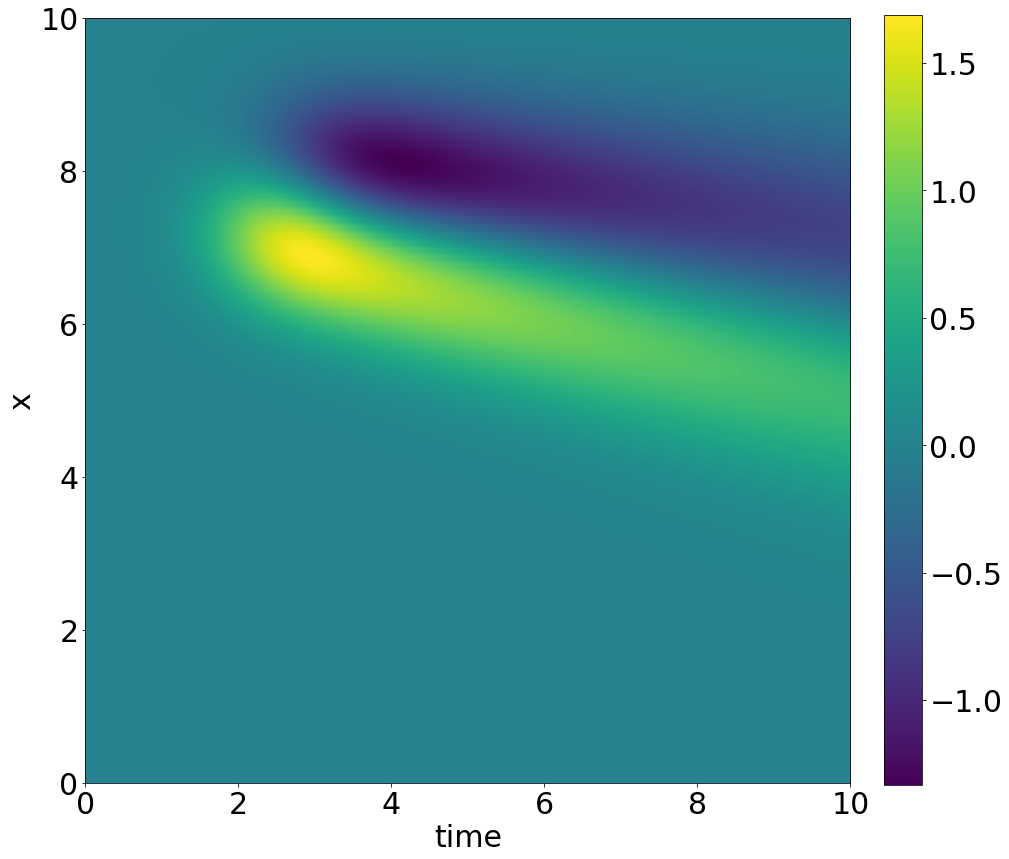

In [240]:
plt.imshow(sourceNew.T,extent=[0,10,0,10],origin='lower')
plt.xlabel("time",fontsize=fontS)
plt.ylabel("x",fontsize=fontS)
plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
cb=plt.colorbar(fraction=0.046, pad=0.04)
cb.ax.tick_params(labelsize = fontS)
plt.savefig('Paper2_ADRLineSource.pdf' )

In [201]:
u1 = 1*np.ones(res)
u2 = 0*np.ones(res)
u=np.array([u1,u2])
windmodel=WindFixU(u) # establish fixed wind model
np.random.seed(1)
N_feat =5000 #Number of features used to infer the source
#k1 = EQ(0.5, 1.0) 
k2 = EQ(0.3, 1) 

mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k2,sensormodel=sensors,windmodel=windmodel,k_0=0.2,R=R) #Initiate new model for inference
concInfer2 = mInfer.computeResponse(sourceNew)

yOut = mInfer.computeObservations()

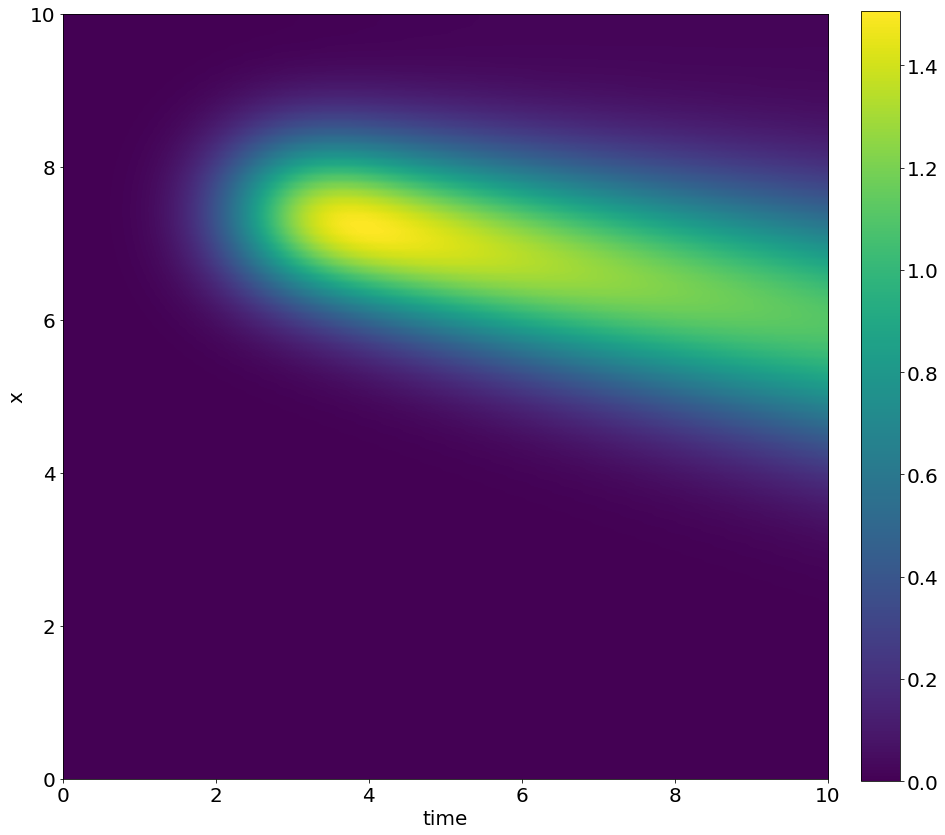

In [215]:
plt.imshow(concInfer2.T,extent=[0,10,0,10],origin='lower')
plt.xlabel("time",fontsize=fontS)
plt.ylabel("x",fontsize=fontS)
plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
cb=plt.colorbar(fraction=0.046, pad=0.04)
cb.ax.tick_params(labelsize = fontS)

In [205]:
np.sum((concInfer2-concTrain)**2)/100000

4.546382024926981e-07

## ADR 2D

In [125]:
#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

#advectionGP

from advectionGP.models.mesh_adr2d_model import AdjointAdvectionDiffusionReaction2DModel as PDEModel

from advectionGP.wind import WindFixU#Wind model


from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
#from advectionGP.test import TestKernels #Unit test model


#Plotting tools
import matplotlib.pyplot as plt

In [126]:
# generate sensor locations for training data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(1,9,10) # lower time
xloc=np.linspace(1,9,5) # x locations
yloc=np.linspace(1,9,5) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] #lower time
X[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1] # x location
X[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2] # ylocation
X[:,1] = X[:,0]+0.1 # upper time

sensors = FixedSensorModel(X,0.1) # establish sensor model arguments are sensor locations and spatial averaging

In [127]:
k_0 = 0.1 #Diffusion
R=1
noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0,0,0],[10,10,10])# corners of the grid - in units of space
k = EQ(2, 2.0) # generate EQ kernel arguments are lengthscale and variance
res = [200,50,50] # grid size for time, x and y

gg = []
for d in range(3):
    gg.append(np.linspace(boundary[0][d],boundary[1][d],res[d]))
        
coords=np.asarray(np.meshgrid(gg[0],gg[1],gg[2],indexing='ij'))


u1 = 0.5*np.sin(-5*coords[1])
u2 = 0*np.ones(res)
u=np.array([u1,u2])
windmodel=WindFixU(u) # establish fixed wind model
m = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=R) #initiate PDE model to build concentration

delta,Ns = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source

sourceGT=(m.computeSourceFromPhi(z))# Compute source

c:\users\chris\documents\github\advectiongp\advectionGP\models\mesh_adr2d_model.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  if (delta[1]>=2*self.k_0/np.min(np.abs(self.u))): print("WARNING: spatial grid size does not meet the finite difference advection diffusion stability criteria")


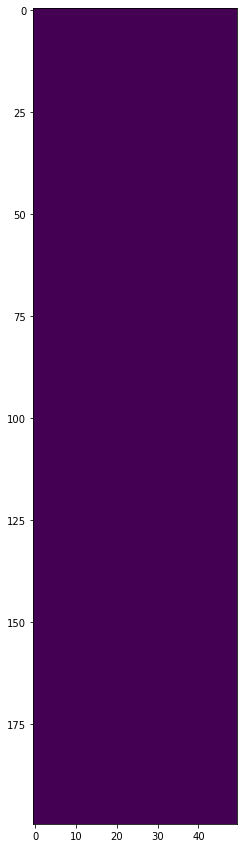

In [128]:
plt.imshow(u1[:,20,:])

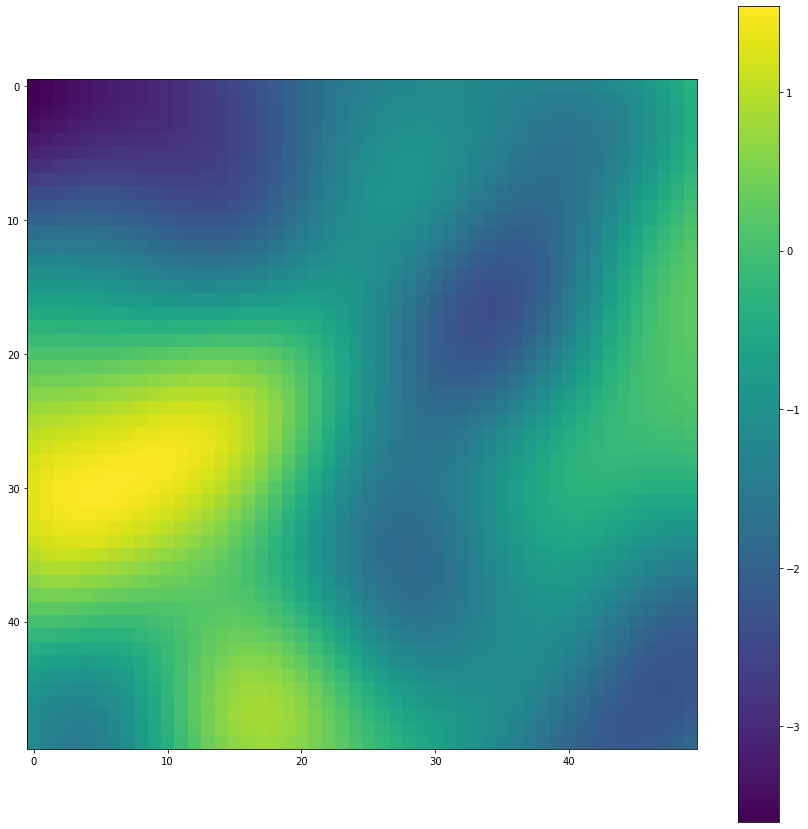

In [129]:
plt.imshow(sourceGT[0])
plt.colorbar()

In [130]:
m.sensormodel=sensors
concTrain=m.computeResponse(sourceGT) # Compute concentration - runs advection diffusion forward model
#concTrain[concTrain<0]=0
#m.concentration=concTrain
yTrain= m.computeObservations(addNoise=True) # Compute observations with noise uses m.sensormodel for observation locations

In [131]:
N_feat =200 #Number of features used to infer the source
k1 = EQ(2, 2.0) 
k2 = EQ(0.3, 2.0) 

mInfer = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k1,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=R) #Initiate new model for inference
regressInfer = mInfer.computeModelRegressors() # Compute regressor matrix
meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance
sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using inferred distributio

concInfer = mInfer.computeResponse(sourceInfer)

yOut = mInfer.computeObservations()



Computing SS...
Inverting SS...
Computing meanZ
Done


In [132]:
meanSource, varSource  = mInfer.computeSourceDistribution(meanZ,covZ)

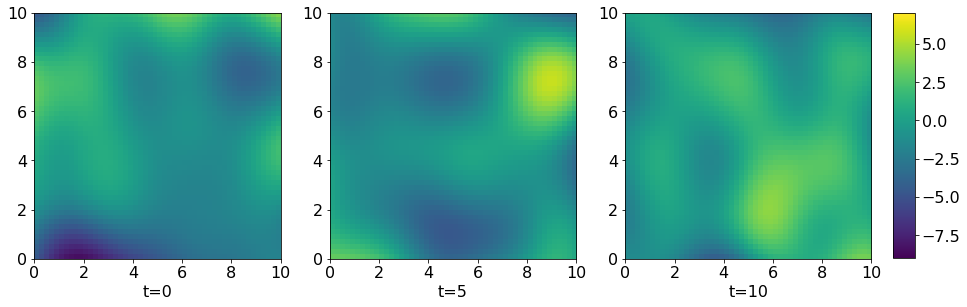

In [133]:
source=sourceInfer
a=np.floor(np.min(source))
b=np.ceil(np.max(source))
plt.rcParams["figure.figsize"] = (15,10)
fig = plt.figure()

plt.subplot(131)
im1=plt.imshow(source[0], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=0",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)
#cbar = plt.colorbar(im1,fraction=0.046, pad=0.04)
tick_font_size = 16
#cbar.ax.tick_params(labelsize = tick_font_size)

plt.subplot(132)
im2=plt.imshow(source[99], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=5",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)
#cbar = plt.colorbar(im2,fraction=0.046, pad=0.04)
tick_font_size = 16
#cbar.ax.tick_params(labelsize = tick_font_size)

plt.subplot(133)
im3=plt.imshow(source[199], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=10",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)

fig.subplots_adjust(bottom=0.25)
cbar_ax = fig.add_axes([0.92, 0.395, 0.02, 0.34])
cbar=fig.colorbar(im1, cax=cbar_ax,orientation='vertical')
#cbar = plt.colorbar(im3,fraction=0.046)
tick_font_size = 16
cbar.ax.tick_params(labelsize = tick_font_size)
plt.show()

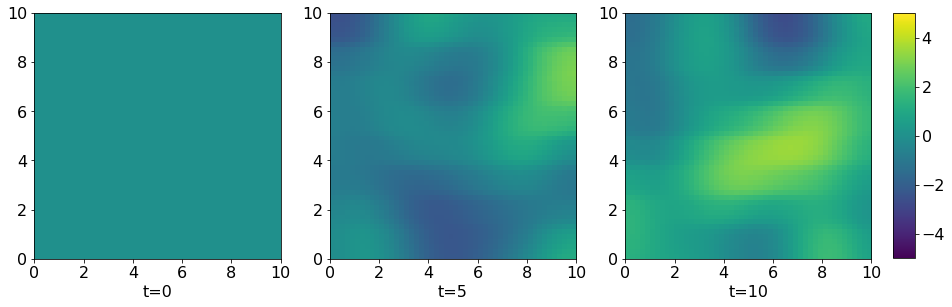

In [134]:
a=np.floor(np.min(concInfer))
b=np.ceil(np.max(concInfer))
plt.rcParams["figure.figsize"] = (15,10)
fig = plt.figure()

plt.subplot(131)
im1=plt.imshow(concTrain[0], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=0",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)
#cbar = plt.colorbar(im1,fraction=0.046, pad=0.04)
tick_font_size = 16
#cbar.ax.tick_params(labelsize = tick_font_size)

plt.subplot(132)
im2=plt.imshow(concTrain[99], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=5",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)
#cbar = plt.colorbar(im2,fraction=0.046, pad=0.04)
tick_font_size = 16
#cbar.ax.tick_params(labelsize = tick_font_size)

plt.subplot(133)
im3=plt.imshow(concTrain[199], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=10",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)

fig.subplots_adjust(bottom=0.25)
cbar_ax = fig.add_axes([0.92, 0.395, 0.02, 0.34])
cbar=fig.colorbar(im1, cax=cbar_ax,orientation='vertical')
#cbar = plt.colorbar(im3,fraction=0.046)
tick_font_size = 16
cbar.ax.tick_params(labelsize = tick_font_size)
plt.show()

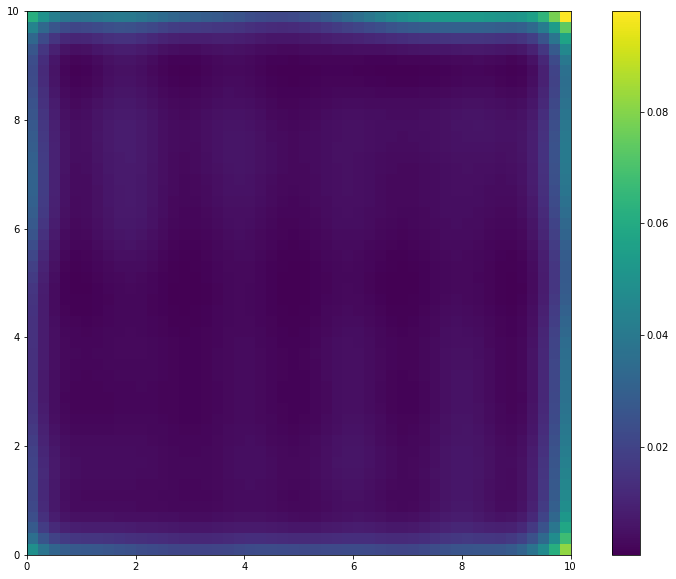

In [135]:
plt.imshow(varSource[99], extent=[0,10,0,10],origin='lower')
plt.colorbar()